In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import geopandas as gpd
from datetime import datetime
neighborhoods = gpd.read_file("SDPD_Beats_shapefile/SDPD_Beats.shp")
neighborhoods['area'] = neighborhoods.geometry.area
neighborhoods = neighborhoods[neighborhoods['area'] > 150000]
zones = gpd.read_file("Zoning_Base_SD_shapefile/Zoning_Base_SD.shp")
folder_path = Path('stops_files')
transit_dfs = {}
for file in folder_path.glob("*.txt"):
    df = pd.read_csv(file)
    file_name = str(file.name)
    file_name = file_name.replace('.txt', '')
    transit_dfs[file_name] = df


common_cols = set(transit_dfs['1206'].columns)
for df in transit_dfs.values():
    common_cols = common_cols.intersection(df.columns)
    
for yymm in transit_dfs:
    df = transit_dfs[yymm]
    df = df[list(common_cols)]
    df = df.drop(['stop_code', 'stop_place', 'reference_place', 'parent_station', 'wheelchair_boarding', 'intersection_code', 'stop_name'], axis=1)
    transit_dfs[yymm] = df
transit_gdfs = {}
for yymm in transit_dfs:
    transit_gdfs[yymm] = gpd.GeoDataFrame(transit_dfs[yymm], geometry=gpd.points_from_xy(y=transit_dfs[yymm].stop_lat, x=transit_dfs[yymm].stop_lon), crs="EPSG:4326")

,stop_lat,stop_id,stop_name_short,location_type,stop_lon
4332,32.716268,11tbro,11tbro,1,-117.154649
4333,32.706002,12tS,12tS,1,-117.153378
4334,32.661844,24tro,24tro,1,-117.107983
4335,32.661854,24tS,24tS,1,-117.108017
4336,32.705307,25tS,25tS,1,-117.140200
...,...,...,...,...,...
4429,32.869208,utcS,utcS,1,-117.214046
4430,32.874196,vahS,vahS,1,-117.229890
4431,32.881852,voiS,voiS,1,-117.223526
4432,32.741635,wasS,wasS,1,-117.184389


In [3]:
uncounted_zones = zones[zones["ZONE_NAME"].isin(["AR-1-1", "AG-1-1", "AR-1-2"])]
zones_cleaned = zones[~zones["ZONE_NAME"].isin(["AR-1-1", "AG-1-1", "AR-1-2"])]
neighborhoods = neighborhoods.to_crs(zones_cleaned.crs)
neighborhoods_cleaned = gpd.overlay(neighborhoods, uncounted_zones, how='difference')
zones_with_neighborhoods = gpd.overlay(zones_cleaned, neighborhoods_cleaned[['NAME', 'geometry']], how='intersection')
zones_with_neighborhoods = zones_with_neighborhoods.rename(columns={'NAME': 'neighborhood'})
zones_with_neighborhoods['centroid'] = zones_with_neighborhoods.geometry.centroid
zones_centroids = zones_with_neighborhoods.set_geometry('centroid')
zones_centroids['buffer'] = zones_centroids.geometry.buffer(850)
zones_buffers = zones_centroids.set_geometry('buffer')


/var/folders/zf/1s145dnx53b_5zr2zxzzh0bc0000gn/T/ipykernel_32808/271928524.py:4: UserWarning: `keep_geom_type=True` in overlay resulted in 606 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  neighborhoods_cleaned = gpd.overlay(neighborhoods, uncounted_zones, how='difference')
/var/folders/zf/1s145dnx53b_5zr2zxzzh0bc0000gn/T/ipykernel_32808/271928524.py:5: UserWarning: `keep_geom_type=True` in overlay resulted in 23 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  zones_with_neighborhoods = gpd.overlay(zones_cleaned, neighborhoods_cleaned[['NAME', 'geometry']], how='intersection')


In [4]:
counts_zone_based = zones_buffers.drop(['centroid', 'Shape_Leng', 'Shape_Area', 'IMP_DATE'], axis=1)
def nearby_counter(transit_gdf, yymm):
    transit_gdf = transit_gdf.to_crs(zones_cleaned.crs)
    joined = gpd.sjoin(transit_gdf, zones_buffers, how='left', predicate='within')
    count_series = joined.groupby('index_right').size()
    counts_zone_based[yymm] = zones_buffers.index.map(count_series).fillna(0).astype(int)
for yymm in transit_gdfs:
    nearby_counter(transit_gdfs[yymm], yymm)

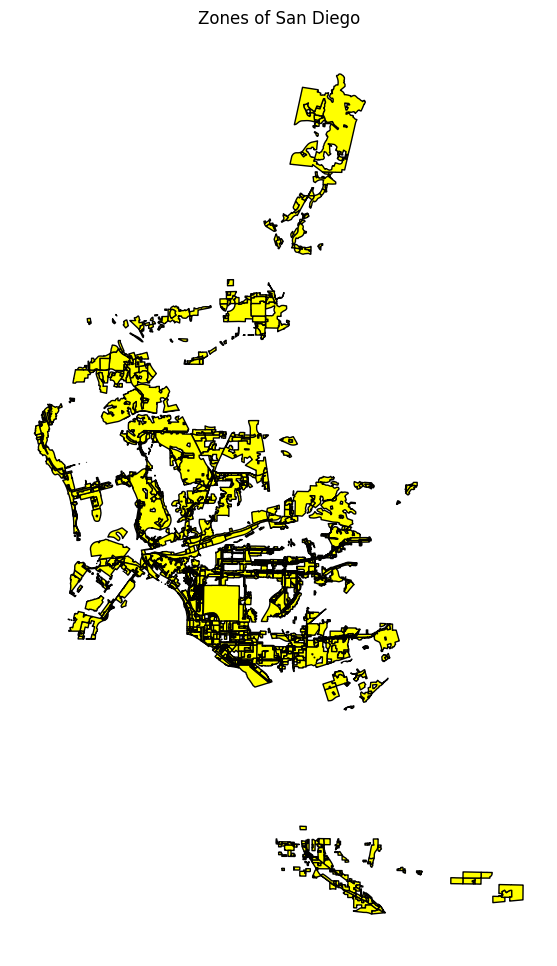

In [8]:
counts_zone_based.drop('buffer', axis = 1)
counts_zone_based = counts_zone_based.set_geometry('geometry')
non_num_cols = ['ZONE_NAME', 'ORDNUM', 'neighborhood', 'buffer', 'geometry']
cols_to_check = [col for col in counts_zone_based.columns if col not in non_num_cols]

counts_zone_based = counts_zone_based[(counts_zone_based[cols_to_check] != 0).any(axis=1)]
counts_zone_based.plot(figsize=(12, 12), color="yellow", edgecolor="black")
plt.title("Zones of San Diego", fontsize=12)
plt.axis("off")
plt.show()


In [6]:
counts_zone_based

,ZONE_NAME,ORDNUM,neighborhood,geometry,buffer,1709,1906,2406,2201,2001,...,2209,1701,1501,1306,2009,1706,1909,2409,1301,1506
0,RM-1-3,R-301263,CARMEL MOUNTAIN,"POLYGON ((6306004.248 1933980.656, 6305986.248...","POLYGON ((6307077.432 1934526.684, 6307073.339...",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,RM-2-4,R-301263,CARMEL MOUNTAIN,"POLYGON ((6309888.093 1935060.415, 6309948.016...","POLYGON ((6310427.083 1935340.553, 6310422.99 ...",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,RM-1-1,R-301263,CARMEL MOUNTAIN,"POLYGON ((6306771.024 1935335, 6306770.995 193...","POLYGON ((6308154.757 1935651.285, 6308150.664...",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,CC-1-1,R-301263,MORENA,"POLYGON ((6270111.999 1859706, 6270176.626 185...","POLYGON ((6270878.746 1859633.635, 6270874.653...",4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
4,CC-1-1,R-301263,LINDA VISTA,"POLYGON ((6279512.957 1868202.38, 6279389.409 ...","POLYGON ((6279973.095 1867898.983, 6279969.002...",3,3,3,3,3,...,3,3,4,4,3,3,3,3,3,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4733,RS-1-14,R-301263,UNIVERSITY CITY,"POLYGON ((6262015.756 1906038.841, 6261715.847...","POLYGON ((6262720.864 1906122.943, 6262716.771...",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4734,IP-1-1,R-301263,UNIVERSITY CITY,"POLYGON ((6261799.287 1903888.396, 6261776.108...","POLYGON ((6262572.487 1904397.392, 6262568.394...",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4735,IP-1-1,R-301263,TORREY PINES,"POLYGON ((6261520.032 1903951.639, 6261526.758...","POLYGON ((6262389.343 1904179.091, 6262385.25 ...",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4736,RS-1-14,R-301263,UNIVERSITY CITY,"POLYGON ((6261577 1903034, 6261551 1902964, 62...","POLYGON ((6262354.075 1902891.379, 6262349.982...",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
